In [11]:
import pandas as pd
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

import os

# for reproducibility
import numpy as np
np.random.seed(42)

In [12]:
# load dataset
dataset = load_dataset("fancyzhx/amazon_polarity")

df_train = pd.DataFrame(dataset['train']).head(6000)
df_test = pd.DataFrame(dataset['test']).head(6000)

In [13]:
# Function to create hierarchically nested training subsets
def create_specific_splits(data, sizes):
    splits = {}
    for size in sizes:
        if size <= len(data):
            split_data = data.head(size)
            splits[f"train_{size}"] = split_data
            print(f"Split with {size} samples created in memory.")
    return splits

def tokenize_function(examples):
    return tokenizer(examples['content'], padding="max_length", truncation=True)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [14]:
# Create the requested splits
sizes = [50, 100, 200, 400, 800, 1000, 6000]  # Added 6000 for the full dataset
nested_splits = create_specific_splits(df_train, sizes)
nested_splits = {key: Dataset.from_pandas(value) for key, value in nested_splits.items()}

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize all datasets
nested_splits_tokenized = {key: value.map(tokenize_function, batched=True) for key, value in nested_splits.items()}
test_tokenized = dataset['test'].select(range(6000)).map(tokenize_function, batched=True).with_format('torch')

os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="results",
    eval_strategy="epoch",  # Log at each epoch
    logging_strategy="epoch",  # Ensure that you log at each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="logs",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Split with 50 samples created in memory.
Split with 100 samples created in memory.
Split with 200 samples created in memory.
Split with 400 samples created in memory.
Split with 800 samples created in memory.
Split with 1000 samples created in memory.
Split with 6000 samples created in memory.


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [15]:
# Training and evaluation loop
losses_per_epoch = {}
results = {}

for size, train_dataset in nested_splits_tokenized.items():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Reinitialize the model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset.with_format('torch'),
        eval_dataset=test_tokenized,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )
    
    print(f"Training on subset: {size}")
    trainer.train()
    evaluation_results = trainer.evaluate()
    results[size] = evaluation_results
    print(f"Evaluation Results for {size}: {evaluation_results}")
    
    # Collect loss data
    train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    losses_per_epoch[size] = train_loss

    # Save model and tokenizer
    model_output_dir = f"results/{size}_model"
    tokenizer_output_dir = f"results/{size}_tokenizer"
    model.save_pretrained(model_output_dir)
    tokenizer.save_pretrained(tokenizer_output_dir)
    print(f"Model and tokenizer saved in {model_output_dir} and {tokenizer_output_dir} respectively.")

# Print all results
print("All Evaluation Results:", results)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training on subset: train_50


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.683300,0.685060,0.516000,0.680739,0.516000,1.000000
2,0.675600,0.681627,0.516000,0.680739,0.516000,1.000000
3,0.660000,0.678828,0.516000,0.680739,0.516000,1.000000
4,0.651200,0.676752,0.516000,0.680739,0.516000,1.000000
5,0.634700,0.675606,0.516000,0.680739,0.516000,1.000000


Evaluation Results for train_50: {'eval_loss': 0.6850602030754089, 'eval_accuracy': 0.516, 'eval_f1': 0.6807387862796834, 'eval_precision': 0.516, 'eval_recall': 1.0, 'eval_runtime': 42.3016, 'eval_samples_per_second': 141.839, 'eval_steps_per_second': 1.111, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved in results/train_50_model and results/train_50_tokenizer respectively.
Training on subset: train_100


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.696100,0.695952,0.502667,0.663433,0.509705,0.949935
2,0.691200,0.693120,0.515000,0.676882,0.515736,0.984496
3,0.678700,0.691308,0.517500,0.679082,0.516962,0.989341
4,0.674800,0.690169,0.519667,0.680062,0.518099,0.989341
5,0.672400,0.689586,0.520333,0.680151,0.518468,0.988372


Evaluation Results for train_100: {'eval_loss': 0.6895862817764282, 'eval_accuracy': 0.5203333333333333, 'eval_f1': 0.6801511446988219, 'eval_precision': 0.518468315825144, 'eval_recall': 0.9883720930232558, 'eval_runtime': 42.634, 'eval_samples_per_second': 140.733, 'eval_steps_per_second': 1.102, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved in results/train_100_model and results/train_100_tokenizer respectively.
Training on subset: train_200


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.702300,0.693669,0.515833,0.680453,0.515930,0.999031
2,0.681600,0.690778,0.515833,0.680594,0.515919,0.999677
3,0.672600,0.688822,0.516000,0.680669,0.516005,0.999677
4,0.673400,0.687489,0.516500,0.680823,0.516269,0.999354
5,0.666600,0.686949,0.516500,0.680753,0.516274,0.999031


Evaluation Results for train_200: {'eval_loss': 0.6874894499778748, 'eval_accuracy': 0.5165, 'eval_f1': 0.680822972824293, 'eval_precision': 0.5162689804772235, 'eval_recall': 0.9993540051679587, 'eval_runtime': 43.1172, 'eval_samples_per_second': 139.156, 'eval_steps_per_second': 1.09, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved in results/train_200_model and results/train_200_tokenizer respectively.
Training on subset: train_400


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.689800,0.690895,0.516000,0.680739,0.516000,1.000000
2,0.681400,0.688548,0.516000,0.680739,0.516000,1.000000
3,0.663600,0.684391,0.516500,0.680823,0.516269,0.999354
4,0.664400,0.680298,0.525167,0.683620,0.520900,0.994186
5,0.657200,0.678334,0.530667,0.684446,0.524022,0.986434


Evaluation Results for train_400: {'eval_loss': 0.6783336400985718, 'eval_accuracy': 0.5306666666666666, 'eval_f1': 0.6844464365755266, 'eval_precision': 0.5240219629375429, 'eval_recall': 0.9864341085271318, 'eval_runtime': 40.8181, 'eval_samples_per_second': 146.994, 'eval_steps_per_second': 1.151, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved in results/train_400_model and results/train_400_tokenizer respectively.
Training on subset: train_800


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.693300,0.685864,0.510167,0.108584,0.890547,0.057817
2,0.676200,0.675435,0.541333,0.212815,0.930000,0.120155
3,0.655900,0.657223,0.638667,0.481588,0.927256,0.325258
4,0.627700,0.635765,0.700500,0.612632,0.920933,0.458979
5,0.603500,0.624667,0.712500,0.633213,0.926571,0.480943


Evaluation Results for train_800: {'eval_loss': 0.6246672868728638, 'eval_accuracy': 0.7125, 'eval_f1': 0.6332128428662557, 'eval_precision': 0.926571250777847, 'eval_recall': 0.48094315245478036, 'eval_runtime': 42.4268, 'eval_samples_per_second': 141.42, 'eval_steps_per_second': 1.108, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved in results/train_800_model and results/train_800_tokenizer respectively.
Training on subset: train_1000


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.689100,0.694020,0.484000,0.000000,0.000000,0.000000
2,0.669600,0.674468,0.504500,0.081557,0.936170,0.042636
3,0.631900,0.639392,0.642167,0.490387,0.924799,0.333656
4,0.589500,0.603294,0.717667,0.645903,0.915284,0.499031
5,0.551800,0.584501,0.745000,0.695462,0.906120,0.564276


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results for train_1000: {'eval_loss': 0.5845005512237549, 'eval_accuracy': 0.745, 'eval_f1': 0.6954617834394905, 'eval_precision': 0.9061203319502075, 'eval_recall': 0.5642764857881137, 'eval_runtime': 41.8391, 'eval_samples_per_second': 143.406, 'eval_steps_per_second': 1.123, 'epoch': 5.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and tokenizer saved in results/train_1000_model and results/train_1000_tokenizer respectively.
Training on subset: train_6000


/tmp/ipykernel_1917/3160480789.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.535100,0.302829,0.879167,0.881787,0.890352,0.873385
2,0.246700,0.265769,0.897500,0.897891,0.923813,0.873385
3,0.178000,0.262327,0.902500,0.905202,0.908293,0.902132
4,0.139100,0.272173,0.902333,0.904622,0.911745,0.897610
5,0.115700,0.276624,0.902000,0.904359,0.910878,0.897933


Evaluation Results for train_6000: {'eval_loss': 0.2623266577720642, 'eval_accuracy': 0.9025, 'eval_f1': 0.9052017501215364, 'eval_precision': 0.9082926829268293, 'eval_recall': 0.9021317829457365, 'eval_runtime': 43.1473, 'eval_samples_per_second': 139.059, 'eval_steps_per_second': 1.089, 'epoch': 5.0}
Model and tokenizer saved in results/train_6000_model and results/train_6000_tokenizer respectively.
All Evaluation Results: {'train_50': {'eval_loss': 0.6850602030754089, 'eval_accuracy': 0.516, 'eval_f1': 0.6807387862796834, 'eval_precision': 0.516, 'eval_recall': 1.0, 'eval_runtime': 42.3016, 'eval_samples_per_second': 141.839, 'eval_steps_per_second': 1.111, 'epoch': 5.0}, 'train_100': {'eval_loss': 0.6895862817764282, 'eval_accuracy': 0.5203333333333333, 'eval_f1': 0.6801511446988219, 'eval_precision': 0.518468315825144, 'eval_recall': 0.9883720930232558, 'eval_runtime': 42.634, 'eval_samples_per_second': 140.733, 'eval_steps_per_second': 1.102, 'epoch': 5.0}, 'train_200': {'eval_l

        Model  Accuracy  F1-Score  Precision    Recall
0    train_50  0.516000  0.680739   0.516000  1.000000
1   train_100  0.520333  0.680151   0.518468  0.988372
2   train_200  0.516500  0.680823   0.516269  0.999354
3   train_400  0.530667  0.684446   0.524022  0.986434
4   train_800  0.712500  0.633213   0.926571  0.480943
5  train_1000  0.745000  0.695462   0.906120  0.564276
6  train_6000  0.902500  0.905202   0.908293  0.902132


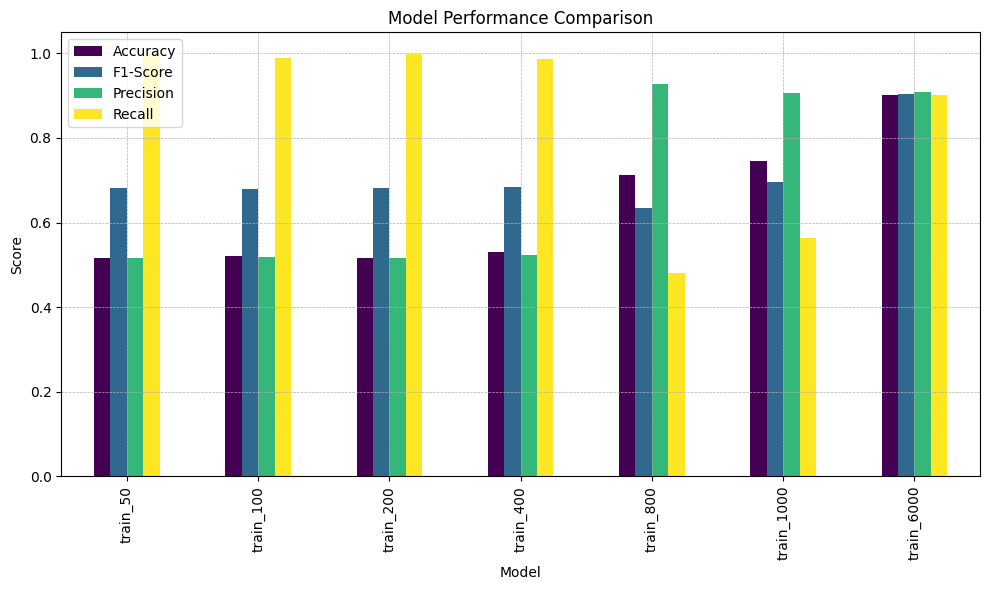

In [16]:
# Create a list to accumulate data
data = []

# Iterate over results to populate the list
for model_size, metrics in results.items():
    data.append({
        "Model": model_size,
        "Accuracy": metrics["eval_accuracy"],
        "F1-Score": metrics["eval_f1"],
        "Precision": metrics["eval_precision"],
        "Recall": metrics["eval_recall"]
    })

# Create a DataFrame
comparison = pd.DataFrame(data)

# Display the DataFrame
print(comparison)

# Visualize the comparison
comparison.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.show()

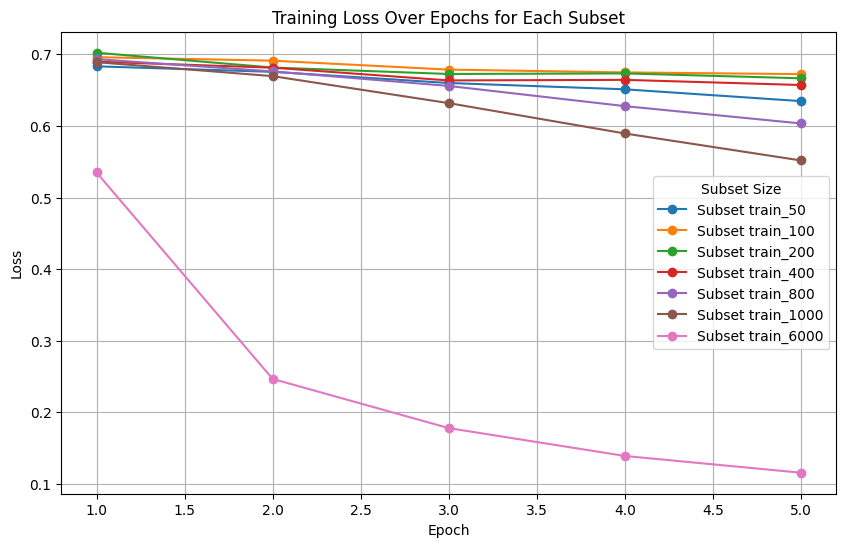

In [18]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(10, 6))
for size, losses in losses_per_epoch.items():
    ax.plot(range(1, len(losses) + 1), losses, marker='o', label=f'Subset {size}')

ax.set_title('Training Loss Over Epochs for Each Subset')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(title='Subset Size')
plt.grid(True)
plt.show()